In [1]:
from data import create_dataset, make_DataLoader, data_visualization

from model import Scene_Graph_Model

from utils import train_model, test_model, count_parameters, plot_loss, print_relationships

import torch as th

/orfeo/cephfs/home/dssc/stumino/deep_learning/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# Data Generation

`NUM_IMAGES` images of simple geometric shapes (rectangles, circles and triangles) are going to be generated using matplotlib.

A random number of shapes (maximum in `MAX_OBJECTS`) will be placed on a `IMAGE_SIZE`x`IMAGE_SIZE` image with a white background, with random colors and positions.

The images and the corresponding annotations (class labels and bounding boxes) will be th.saved.

## Image generation

In [2]:
#Constants
TRAIN_IMAGE_DIR = 'train_images'
TEST_IMAGE_DIR = 'test_images'
DATA_DIR = 'data'
TRAIN_ANNOTATIONS = 'train_data.tensor'
TEST_ANNOTATIONS = 'test_data.tensor'
IMAGE_SIZE = 128
SHAPE_SIZE_MIN = 10
SHAPE_SIZE_MAX = 35
NUM_TRAIN_IMAGES = 10000
NUM_TEST_IMAGES = 2000
MAX_OBJECTS = 5

In [3]:
# Generate images
train_data, train_relationships = create_dataset(NUM_TRAIN_IMAGES, IMAGE_SIZE, TRAIN_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX)

# save annotations
th.save(train_data, DATA_DIR + '/' + TRAIN_ANNOTATIONS)
th.save(train_relationships, DATA_DIR + '/train_relationships.tensor')

The directory train_images already exists. Do you want to delete it? [y/n]


 y


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:42<00:00, 15.58it/s]


In [4]:
# Generate images
test_data, test_relationships = create_dataset(NUM_TEST_IMAGES, IMAGE_SIZE, TEST_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX)

# save annotations
th.save(test_data, DATA_DIR + '/' + TEST_ANNOTATIONS)
th.save(test_relationships, DATA_DIR + "/test_relationships.tensor")

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:21<00:00, 14.14it/s]


## Display Data

### Data Visualization

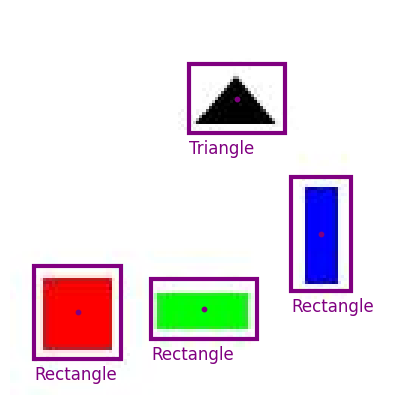

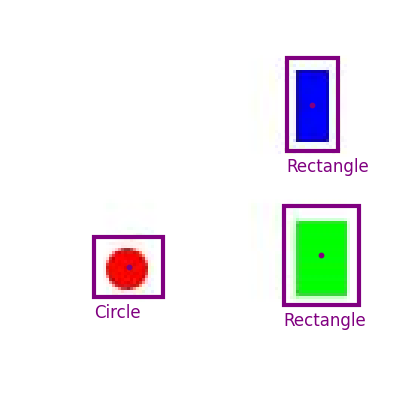

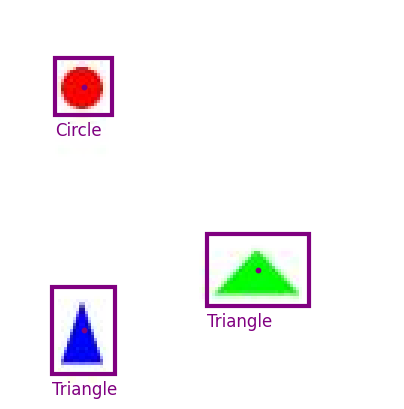

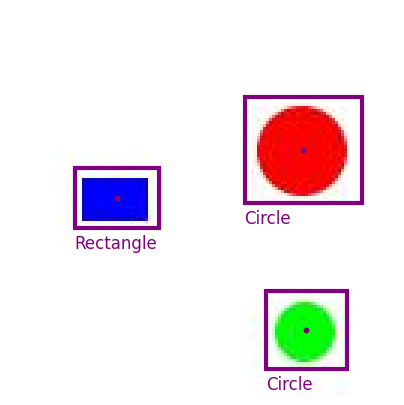

In [5]:
data_visualization()

## DataLoader

### Image loading

In [6]:
make_DataLoader(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR, IMAGE_SIZE, DATA_DIR, TRAIN_ANNOTATIONS, TEST_ANNOTATIONS)

Loading the images in test_images...: 100%|██████████████████████████████████████| 2000/2000 [00:00<00:00, 2908.73it/s]


# Model

In [7]:
train_loader = th.load('./dataloaders/train_loader.tensor')
test_loader = th.load('./dataloaders/test_loader.tensor')

In [8]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)

criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :4], y[:, 0, :4]) \
                            + th.nn.functional.cross_entropy(y_hat[:, 1, :4], y[:, 1, :4]) \
                            + th.nn.functional.cross_entropy(y_hat[:, 2, :4], y[:, 2, :4]) \
                            + th.nn.functional.cross_entropy(y_hat[:, 3, :4], y[:, 3, :4]) \
                            + th.nn.functional.cross_entropy(y_hat[:, 4, :4], y[:, 4, :4]) \
                            + th.nn.functional.mse_loss(y_hat[:, :, 4:], y[:, :, 4:]) \
                            + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)
                           
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
model, train_loss, test_loss = train_model(model, optimizer, criterion, train_loader, test_loader, 200)

Loss 9.3926/8.4827, Acc 1.00/0.99, Relation: 0.93/0.93: 100%|████████████████████████| 200/200 [11:12<00:00,  3.36s/it]


In [10]:
count_parameters(model)

+-------------------------------+------------+
|            Modules            | Parameters |
+-------------------------------+------------+
|       block1.0.0.weight       |    432     |
|        block1.0.0.bias        |     16     |
|       block1.0.1.weight       |     16     |
|        block1.0.1.bias        |     16     |
|       block1.1.0.weight       |    4608    |
|        block1.1.0.bias        |     32     |
|       block1.1.1.weight       |     32     |
|        block1.1.1.bias        |     32     |
|       block1.2.0.weight       |   18432    |
|        block1.2.0.bias        |     64     |
|       block1.2.1.weight       |     64     |
|        block1.2.1.bias        |     64     |
|       block1.3.0.weight       |   73728    |
|        block1.3.0.bias        |    128     |
|       block1.3.1.weight       |    128     |
|        block1.3.1.bias        |    128     |
|       block1.4.0.weight       |   32768    |
|        block1.4.0.bias        |    256     |
|       block

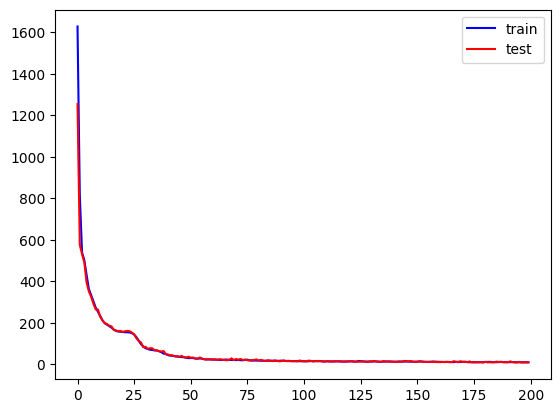

In [11]:
plot_loss(train_loss, test_loss)

In [21]:
# save the modeldata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAjAAAAGdCAYAAAAMm0nCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAABOo0lEQVR4nO3deXwU9f3H8dcmm92cuyFAsomEQ0QEQRDQGA88SAlH8cIqmipUhGrBeov8qtSromg9sCq1VbEVq7X1qFjRCAgKIXIYUcAgGAlXEq7s5s4mO78/YrasXMmyyZDwfj4e8yCZ+e7sZzKQffOZy2IYhoGIiIhIGxJmdgEiIiIizaUAIyIiIm2OAoyIiIi0OQowIiIi0uYowIiIiEibowAjIiIibY4CjIiIiLQ5CjAiIiLS5ljNLqCl+Hw+duzYQVxcHBaLxexyREREpAkMw6CsrIyUlBTCwg7dZ2m3AWbHjh2kpqaaXYaIiIgEYevWrXTp0uWQy9ttgImLiwMafgAOh8PkakRERKQpPB4Pqamp/s/xQ2m3AabxsJHD4VCAERERaWOOdPqHTuIVERGRNkcBRkRERNocBRgRERFpc9rtOTAiIiItpb6+Hq/Xa3YZbVJ4eDhWq/Wob3GiACMiItIM5eXlbNu2DcMwzC6lzYqOjiY5ORmbzRb0OhRgREREmqi+vp5t27YRHR1N586ddaPUZjIMg9raWnbt2kVBQQG9evU67M3qDkcBRkREpIm8Xi+GYdC5c2eioqLMLqdNioqKIiIigi1btlBbW0tkZGRQ69FJvCIiIs2kzsvRCbbrErCOENQhIiIi0qoUYERERKTNUYARERGRJuvevTtPP/202WXoJF4REZH27oILLmDgwIEhCR4rV64kJibm6Is6SurANNP778Mtt8A775hdiYiISGgYhkFdXV2Txnbu3Jno6OgWrujIFGCaaflymD0bli41uxIRETGbYUBFhTlTU++jN2HCBJYsWcIzzzyDxWLBYrEwd+5cLBYLH374IYMHD8Zut/P555+zefNmLrnkEpKSkoiNjeWMM87gk08+CVjfTw8hWSwW/vrXv3LZZZcRHR1Nr169+M9//hPCn/LBKcA0U3h4w59NDKoiItKOVVZCbKw5U2Vl02p85plnSE9PZ9KkSezcuZOdO3eSmpoKwD333MOjjz7Khg0bOO200ygvL2fUqFEsXLiQL7/8khEjRjBmzBgKCwsP+x4PPPAAV155JWvXrmXUqFFkZWWxd+/eo/3xHlazA8zSpUsZM2YMKSkpWCwW3n333QPGbNiwgYsvvhin00lMTAxnnHFGwMZXV1czZcoUOnbsSGxsLGPHjqW4uDhgHYWFhYwePZro6GgSExO56667mtzeaknWH88aqq83tw4REZGmcDqd2Gw2oqOjcblcuFwuwn/83/iDDz7Iz372M3r27ElCQgIDBgzg17/+Nf369aNXr1489NBD9OzZ84gdlQkTJnD11Vdz0kkn8cgjj1BeXs4XX3zRotvV7JN4KyoqGDBgANdffz2XX375Acs3b97Mueeey8SJE3nggQdwOBysW7cu4E57t912Gx988AFvvfUWTqeTqVOncvnll7Ns2TKg4VbNo0ePxuVysXz5cnbu3Ml1111HREQEjzzyyFFs7tFTB0ZERBpFR0N5uXnvfbSGDBkS8H15eTn3338/H3zwATt37qSuro6qqqojdmBOO+00/9cxMTE4HA5KSkqOvsDDaHaAGTlyJCNHjjzk8t/97neMGjWKWbNm+ef17NnT/7Xb7eall17i9ddf56KLLgLglVdeoU+fPqxYsYKzzjqLjz/+mPXr1/PJJ5+QlJTEwIEDeeihh5g2bRr333//UT386WipAyMiIo0sFjgGLsgJ2k+vJrrzzjvJzs7miSee4KSTTiIqKoorrriC2traw64nIiIi4HuLxYLP5wt5vfsL6TkwPp+PDz74gJNPPpnMzEwSExNJS0sLOMy0evVqvF4vGRkZ/nmnnHIKXbt2JScnB4CcnBz69+9PUlKSf0xmZiYej4d169Yd9L1ramrweDwBU0tQB0ZERNoam81GfRP+571s2TImTJjAZZddRv/+/XG5XPzwww8tX2AQQhpgSkpKKC8v59FHH2XEiBF8/PHHXHbZZVx++eUsWbIEgKKiImw2G/Hx8QGvTUpKoqioyD9m//DSuLxx2cHMnDkTp9PpnxpPUAo1dWBERKSt6d69O7m5ufzwww/s3r37kN2RXr168fbbb5OXl8dXX33FNddc0+KdlGCFvAMDcMkll3DbbbcxcOBA7rnnHn7+858zZ86cUL7VAaZPn47b7fZPW7dubZH3UQdGRETamjvvvJPw8HD69u1L586dD3lOy5NPPkmHDh04++yzGTNmDJmZmQwaNKiVq22akN6Jt1OnTlitVvr27Rswv0+fPnz++ecAuFwuamtrKS0tDejCFBcX43K5/GN+evZy41VKjWN+ym63Y7fbQ7Uph9QYYNSBERGRtuLkk0/2n6bRaMKECQeM6969O4sWLQqYN2XKlIDvf3pIyTjIDWlKS0uDqrM5QtqBsdlsnHHGGeTn5wfM37hxI926dQNg8ODBREREsHDhQv/y/Px8CgsLSU9PByA9PZ2vv/464Azm7OxsHA7HAeGotTUeQlIHRkRExDzN7sCUl5ezadMm//cFBQXk5eWRkJBA165dueuuu7jqqqsYOnQoF154IQsWLOD999/n008/BRquR584cSK33347CQkJOBwObr75ZtLT0znrrLMAGD58OH379uXaa69l1qxZFBUVce+99zJlypRW6bIcjjowIiIi5mt2gFm1ahUXXnih//vbb78dgPHjxzN37lwuu+wy5syZw8yZM/ntb39L7969+fe//825557rf81TTz1FWFgYY8eOpaamhszMTJ5//nn/8vDwcObPn89NN91Eeno6MTExjB8/ngcffPBotjUkdBKviIiI+SzGwQ5etQMejwen04nb7cbhcIRsvX/7G4wfD8OHw0cfhWy1IiLSBlRXV1NQUECPHj0CbtAqzXO4n2NTP7/1LKRmUgdGRETEfAowzaTLqEVERMynANNM6sCIiIiYTwGmmdSBERERMZ8CTDOpAyMiImI+BZhmUgdGRETamgsuuIBbb701ZOubMGECl156acjWFwwFmGbSjexERETMpwDTTDqEJCIibcmECRNYsmQJzzzzDBaLBYvFwg8//MA333zDyJEjiY2NJSkpiWuvvZbdu3f7X/evf/2L/v37ExUVRceOHcnIyKCiooL777+fV199lffee8+/vsa77bemkD7M8XigQ0giIuJnGFBZac57R0eDxXLEYc888wwbN26kX79+/jvaR0REcOaZZ3LDDTfw1FNPUVVVxbRp07jyyitZtGgRO3fu5Oqrr2bWrFlcdtlllJWV8dlnn2EYBnfeeScbNmzA4/HwyiuvAJCQkNCim3owCjDNpA6MiIj4VVZCbKw5711eDjExRxzmdDqx2WxER0fjcrkAePjhhzn99NN55JFH/ONefvllUlNT2bhxI+Xl5dTV1XH55Zf7H8bcv39//9ioqChqamr86zODAkwzqQMjIiJt3VdffcXixYuJPUj42rx5M8OHD2fYsGH079+fzMxMhg8fzhVXXEGHDh1MqPbgFGCaSR0YERHxi45u6ISY9d5BKi8vZ8yYMTz22GMHLEtOTiY8PJzs7GyWL1/Oxx9/zLPPPsvvfvc7cnNz6dGjx9FUHTIKMM2kDoyIiPhZLE06jGM2m81G/X7/8x40aBD//ve/6d69O1brwaOAxWLhnHPO4ZxzzmHGjBl069aNd955h9tvv/2A9ZlBVyE1kzowIiLS1nTv3p3c3Fx++OEHdu/ezZQpU9i7dy9XX301K1euZPPmzXz00Uf86le/or6+ntzcXB555BFWrVpFYWEhb7/9Nrt27aJPnz7+9a1du5b8/Hx2796N1+tt9W1SgGkmdWBERKStufPOOwkPD6dv37507tyZ2tpali1bRn19PcOHD6d///7ceuutxMfHExYWhsPhYOnSpYwaNYqTTz6Ze++9lz/+8Y+MHDkSgEmTJtG7d2+GDBlC586dWbZsWatvk8UwDKPV37UVeDwenE4nbrcbh8MRsvVu3Ai9e4PTCaWlIVutiIi0AdXV1RQUFNCjRw8iIyPNLqfNOtzPsamf3+rANJM6MCIiIuZTgGkmPUpARETEfAowzaSTeEVERMynANNMOoQkIiJiPgWYZmrswBgG+Hzm1iIiInK8UoBppsYODOgwkojI8aqdXsDbakLx81OAaab9b1ioACMicnwJ//F/sbW1tSZX0rZV/vgE74iIiKDXoUcJNNP+HRidByMicnyxWq1ER0eza9cuIiIiCAtTH6A5DMOgsrKSkpIS4uPj/YEwGAowzaQOjIjI8ctisZCcnExBQQFbtmwxu5w2Kz4+HpfLdVTrUIBpJnVgRESObzabjV69eukwUpAiIiKOqvPSSAGmmXQSr4iIhIWF6VECJtPBu2ayWKDxkKcCjIiIiDkUYIKgm9mJiIiYSwEmCHqcgIiIiLkUYIKgDoyIiIi5mh1gli5dypgxY0hJScFisfDuu+8ecuyNN96IxWLh6aefDpi/d+9esrKycDgcxMfHM3HiRMrLywPGrF27lvPOO4/IyEhSU1OZNWtWc0ttMerAiIiImKvZAaaiooIBAwbw3HPPHXbcO++8w4oVK0hJSTlgWVZWFuvWrSM7O5v58+ezdOlSJk+e7F/u8XgYPnw43bp1Y/Xq1Tz++OPcf//9vPjii80tt0WoAyMiImKuZl9GPXLkSEaOHHnYMdu3b+fmm2/mo48+YvTo0QHLNmzYwIIFC1i5ciVDhgwB4Nlnn2XUqFE88cQTpKSkMG/ePGpra3n55Zex2Wyceuqp5OXl8eSTTwYEHbOoAyMiImKukJ8D4/P5uPbaa7nrrrs49dRTD1iek5NDfHy8P7wAZGRkEBYWRm5urn/M0KFDsdls/jGZmZnk5+ezb9++g75vTU0NHo8nYGop6sCIiIiYK+QB5rHHHsNqtfLb3/72oMuLiopITEwMmGe1WklISKCoqMg/JikpKWBM4/eNY35q5syZOJ1O/5Samnq0m3JI6sCIiIiYK6QBZvXq1TzzzDPMnTsXi8USylUf0fTp03G73f5p69atLfZe6sCIiIiYK6QB5rPPPqOkpISuXbtitVqxWq1s2bKFO+64g+7duwPgcrkoKSkJeF1dXR179+71P9jJ5XJRXFwcMKbx+0M9/Mlut+NwOAKmlqIOjIiIiLlCGmCuvfZa1q5dS15enn9KSUnhrrvu4qOPPgIgPT2d0tJSVq9e7X/dokWL8Pl8pKWl+ccsXboUr9frH5OdnU3v3r3p0KFDKEsOSmMHRgFGRETEHM2+Cqm8vJxNmzb5vy8oKCAvL4+EhAS6du1Kx44dA8ZHRETgcrno3bs3AH369GHEiBFMmjSJOXPm4PV6mTp1KuPGjfNfcn3NNdfwwAMPMHHiRKZNm8Y333zDM888w1NPPXU02xoyOoQkIiJirmYHmFWrVnHhhRf6v7/99tsBGD9+PHPnzm3SOubNm8fUqVMZNmwYYWFhjB07ltmzZ/uXO51OPv74Y6ZMmcLgwYPp1KkTM2bMOCYuoQYdQhIRETGbxTAMw+wiWoLH48HpdOJ2u0N+PszgwbBmDXzwAYwaFdJVi4iIHNea+vmtZyEFQR0YERERcynABEHnwIiIiJhLASYI6sCIiIiYSwEmCOrAiIiImEsBJgjqwIiIiJhLASYIupGdiIiIuRRggtDYgdEhJBEREXMowARBHRgRERFzKcAEQR0YERERcynABEEdGBEREXMpwARBl1GLiIiYSwEmCLqMWkRExFwKMEFQB0ZERMRcCjBBUAdGRETEXAowQdBJvCIiIuZSgAmCLqMWERExlwJMENSBERERMZcCTBDUgRERETGXAkwQ1IERERExlwJMENSBERERMZcCTBDUgRERETGXAkwQGgKMoQ6MiIiISRRgmuv//o/7HwrjCe5UB0ZERMQkCjDNFRaGxTCwUqcOjIiIiEkUYJrrxzN4rdSpAyMiImISBZjmUoARERExnQJMc+0XYHQISURExBwKMM2lDoyIiIjpFGCaSx0YERER0ynANNePASYCrzowIiIiJml2gFm6dCljxowhJSUFi8XCu+++61/m9XqZNm0a/fv3JyYmhpSUFK677jp27NgRsI69e/eSlZWFw+EgPj6eiRMnUl5eHjBm7dq1nHfeeURGRpKamsqsWbOC28JQUwdGRETEdM0OMBUVFQwYMIDnnnvugGWVlZWsWbOG++67jzVr1vD222+Tn5/PxRdfHDAuKyuLdevWkZ2dzfz581m6dCmTJ0/2L/d4PAwfPpxu3bqxevVqHn/8ce6//35efPHFIDYxxHQOjIiIiOmszX3ByJEjGTly5EGXOZ1OsrOzA+b96U9/4swzz6SwsJCuXbuyYcMGFixYwMqVKxkyZAgAzz77LKNGjeKJJ54gJSWFefPmUVtby8svv4zNZuPUU08lLy+PJ598MiDomCIiAlAHRkRExEwtfg6M2+3GYrEQHx8PQE5ODvHx8f7wApCRkUFYWBi5ubn+MUOHDsVms/nHZGZmkp+fz759+w76PjU1NXg8noCpRagDIyIiYroWDTDV1dVMmzaNq6++GofDAUBRURGJiYkB46xWKwkJCRQVFfnHJCUlBYxp/L5xzE/NnDkTp9Ppn1JTU0O9OY3FNvyhACMiImKaFgswXq+XK6+8EsMweOGFF1rqbfymT5+O2+32T1u3bm2ZN9JJvCIiIqZr9jkwTdEYXrZs2cKiRYv83RcAl8tFSUlJwPi6ujr27t2Ly+XyjykuLg4Y0/h945ifstvt2O32UG7GwakDIyIiYrqQd2Aaw8t3333HJ598QseOHQOWp6enU1payurVq/3zFi1ahM/nIy0tzT9m6dKleL1e/5js7Gx69+5Nhw4dQl1y8+x3Hxh1YERERMzR7ABTXl5OXl4eeXl5ABQUFJCXl0dhYSFer5crrriCVatWMW/ePOrr6ykqKqKoqIja2loA+vTpw4gRI5g0aRJffPEFy5YtY+rUqYwbN46UlBQArrnmGmw2GxMnTmTdunW8+eabPPPMM9x+++2h2/JgqQMjIiJiPqOZFi9ebAAHTOPHjzcKCgoOugwwFi9e7F/Hnj17jKuvvtqIjY01HA6H8atf/cooKysLeJ+vvvrKOPfccw273W6ccMIJxqOPPtqsOt1utwEYbre7uZt4eJ98YhhgrKWfceqpoV21iIjI8a6pn9/NPgfmggsuwDCMwwWiI64jISGB119//bBjTjvtND777LPmltfy9rsPjDowIiIi5tCzkJpLVyGJiIiYTgGmuXQOjIiIiOkUYJpLHRgRERHTKcA0lzowIiIiplOAaa797gOjACMiImIOBZjm0iEkERER0ynANJcOIYmIiJhOAaa59rsPjDowIiIi5lCAaS51YEREREynANNc/gBTT533yHcdFhERkdBTgGku635PX1ALRkRExBQKMM21X4AJM+powqOfREREJMQUYJprvwCje8GIiIiYQwGmufYLMDqRV0RExBwKMM31kwCjS6lFRERanwJMc1ksGOHhgDowIiIiZlGACYYeJyAiImIqBZhg6GZ2IiIiplKACYJFHRgRERFTKcAEQx0YERERUynABOPHABOBVx0YEREREyjABEMdGBEREVMpwARD58CIiIiYSgEmGBERgDowIiIiZlGACYYOIYmIiJhKASYYOoQkIiJiKgWYYKgDIyIiYioFmGCoAyMiImIqBZhg7HcfGHVgREREWp8CTDDUgRERETGVAkwwdA6MiIiIqZodYJYuXcqYMWNISUnBYrHw7rvvBiw3DIMZM2aQnJxMVFQUGRkZfPfddwFj9u7dS1ZWFg6Hg/j4eCZOnEh5eXnAmLVr13LeeecRGRlJamoqs2bNav7WtRR1YEREREzV7ABTUVHBgAEDeO655w66fNasWcyePZs5c+aQm5tLTEwMmZmZVFdX+8dkZWWxbt06srOzmT9/PkuXLmXy5Mn+5R6Ph+HDh9OtWzdWr17N448/zv3338+LL74YxCa2AN3ITkRExFzGUQCMd955x/+9z+czXC6X8fjjj/vnlZaWGna73fjHP/5hGIZhrF+/3gCMlStX+sd8+OGHhsViMbZv324YhmE8//zzRocOHYyamhr/mGnTphm9e/ducm1ut9sADLfbHezmHdqYMYYBxvX81Xj//dCvXkRE5HjV1M/vkJ4DU1BQQFFRERkZGf55TqeTtLQ0cnJyAMjJySE+Pp4hQ4b4x2RkZBAWFkZubq5/zNChQ7HZbP4xmZmZ5Ofns2/fvoO+d01NDR6PJ2BqMTqEJCIiYqqQBpiioiIAkpKSAuYnJSX5lxUVFZGYmBiw3Gq1kpCQEDDmYOvY/z1+aubMmTidTv+Umpp69Bt0KDqJV0RExFTt5iqk6dOn43a7/dPWrVtb7s32uw+MOjAiIiKtL6QBxuVyAVBcXBwwv7i42L/M5XJRUlISsLyuro69e/cGjDnYOvZ/j5+y2+04HI6AqcWoAyMiImKqkAaYHj164HK5WLhwoX+ex+MhNzeX9PR0ANLT0yktLWX16tX+MYsWLcLn85GWluYfs3TpUrxer39MdnY2vXv3pkOHDqEsOTg6B0ZERMRUzQ4w5eXl5OXlkZeXBzScuJuXl0dhYSEWi4Vbb72Vhx9+mP/85z98/fXXXHfddaSkpHDppZcC0KdPH0aMGMGkSZP44osvWLZsGVOnTmXcuHGkpKQAcM0112Cz2Zg4cSLr1q3jzTff5JlnnuH2228P2YYfFXVgRERETGVt7gtWrVrFhRde6P++MVSMHz+euXPncvfdd1NRUcHkyZMpLS3l3HPPZcGCBURGRvpfM2/ePKZOncqwYcMICwtj7NixzJ4927/c6XTy8ccfM2XKFAYPHkynTp2YMWNGwL1iTLXffWDUgREREWl9FsMwDLOLaAkejwen04nb7Q79+TC33AKzZ/Mwv6PTCw9z442hXb2IiMjxqqmf3+3mKqRWpUNIIiIiplKACYZO4hURETGVAkww9rsPjDowIiIirU8BJhjqwIiIiJhKASYYOgdGRETEVAowwVAHRkRExFQKMMHY7z4w6sCIiIi0PgWYYKgDIyIiYioFmGDoHBgRERFTKcAEQx0YERERUynABEP3gRERETGVAkwwdAhJRETEVAowwdAhJBEREVMpwARDHRgRERFTKcAEY7/7wKgDIyIi0voUYIKhDoyIiIipFGCCoXNgRERETKUAEwx1YEREREylABOM/e4Dow6MiIhI61OACYY6MCIiIqZSgAmGAoyIiIipFGCCoZN4RURETKUAE4z97gOjDoyIiEjrU4AJhjowIiIiplKACYbOgRERETGVAkww1IERERExlQJMMPa7D4w6MCIiIq1PASYY6sCIiIiYSgEmGDoHRkRExFQKMMHwB5h66ryGycWIiIgcf0IeYOrr67nvvvvo0aMHUVFR9OzZk4ceegjD+N8HvWEYzJgxg+TkZKKiosjIyOC7774LWM/evXvJysrC4XAQHx/PxIkTKS8vD3W5wfkxwAAYdWrBiIiItLaQB5jHHnuMF154gT/96U9s2LCBxx57jFmzZvHss8/6x8yaNYvZs2czZ84ccnNziYmJITMzk+rqav+YrKws1q1bR3Z2NvPnz2fp0qVMnjw51OUG58cb2QHUVuokGBERkdZmMfZvjYTAz3/+c5KSknjppZf888aOHUtUVBSvvfYahmGQkpLCHXfcwZ133gmA2+0mKSmJuXPnMm7cODZs2EDfvn1ZuXIlQ4YMAWDBggWMGjWKbdu2kZKScsQ6PB4PTqcTt9uNw+EI5SZCVRVERwPQM7GMzcWxoV2/iIjIcaqpn98h78CcffbZLFy4kI0bNwLw1Vdf8fnnnzNy5EgACgoKKCoqIiMjw/8ap9NJWloaOTk5AOTk5BAfH+8PLwAZGRmEhYWRm5t70PetqanB4/EETC1mv0NI3ip1YERERFqb9chDmueee+7B4/FwyimnEB4eTn19PX/4wx/IysoCoKioCICkpKSA1yUlJfmXFRUVkZiYGFio1UpCQoJ/zE/NnDmTBx54INSbc3Dh4f4vvZXe1nlPERER8Qt5B+af//wn8+bN4/XXX2fNmjW8+uqrPPHEE7z66quhfqsA06dPx+12+6etW7e23JuFhWGE/fijq6/DqwwjIiLSqkLegbnrrru45557GDduHAD9+/dny5YtzJw5k/Hjx+NyuQAoLi4mOTnZ/7ri4mIGDhwIgMvloqSkJGC9dXV17N271//6n7Lb7djt9lBvzqFZrVBbi5U6KivB6Wy9txYRETnehbwDU1lZSVhY4GrDw8Px+XwA9OjRA5fLxcKFC/3LPR4Pubm5pKenA5Cenk5paSmrV6/2j1m0aBE+n4+0tLRQlxyc/W5mV1lpci0iIiLHmZB3YMaMGcMf/vAHunbtyqmnnsqXX37Jk08+yfXXXw+AxWLh1ltv5eGHH6ZXr1706NGD++67j5SUFC699FIA+vTpw4gRI5g0aRJz5szB6/UydepUxo0b16QrkFqDRQFGRETENCEPMM8++yz33Xcfv/nNbygpKSElJYVf//rXzJgxwz/m7rvvpqKigsmTJ1NaWsq5557LggULiIyM9I+ZN28eU6dOZdiwYYSFhTF27Fhmz54d6nKD9+O9YBRgREREWl/I7wNzrGjR+8AAuFxQXEx/1vLXFf05Vo5siYiItGWm3QfmuKFDSCIiIqZRgAnWjwEmAq8CjIiISCtTgAmWOjAiIiKmUYAJlgKMiIiIaRRggqUAIyIiYhoFmGApwIiIiJhGASZY+90HpqLC5FpERESOMwowwVIHRkRExDQKMMFSgBERETGNAkywdB8YERER0yjABEsdGBEREdMowARLAUZERMQ0CjDBUoARERExjQJMsBRgRERETKMAE6z97gOjACMiItK6FGCCpQ6MiIiIaRRggqUAIyIiYhoFmGDpPjAiIiKmUYAJljowIiIiplGACdZ+AaaqCnw+k+sRERE5jijABGu/AANQXW1mMSIiIscXBZhg/STA6DCSiIhI61GACdaPAcYergAjIiLS2hRggvXjjeyirAowIiIirU0BJlg/dmAiFWBERERanQJMsBoDTLgXUIARERFpTQowwWo8B0YdGBERkVanABMsncQrIiJiGgWYYDUGmDAFGBERkdamABOsHwOMTR0YERGRVqcAE6zGAKMOjIiISKtrkQCzfft2fvnLX9KxY0eioqLo378/q1at8i83DIMZM2aQnJxMVFQUGRkZfPfddwHr2Lt3L1lZWTgcDuLj45k4cSLl5eUtUW5wfrwPjM2iACMiItLaQh5g9u3bxznnnENERAQffvgh69ev549//CMdOnTwj5k1axazZ89mzpw55ObmEhMTQ2ZmJtX7PVAoKyuLdevWkZ2dzfz581m6dCmTJ08OdbnB+7EDE6EOjIiISKuzhnqFjz32GKmpqbzyyiv+eT169PB/bRgGTz/9NPfeey+XXHIJAH/7299ISkri3XffZdy4cWzYsIEFCxawcuVKhgwZAsCzzz7LqFGjeOKJJ0hJSQl12c3XeAgJ3QdGRESktYW8A/Of//yHIUOG8Itf/ILExEROP/10/vKXv/iXFxQUUFRUREZGhn+e0+kkLS2NnJwcAHJycoiPj/eHF4CMjAzCwsLIzc096PvW1NTg8XgCphbV2IHRISQREZFWF/IA8/333/PCCy/Qq1cvPvroI2666SZ++9vf8uqrrwJQVFQEQFJSUsDrkpKS/MuKiopITEwMWG61WklISPCP+amZM2fidDr9U2pqaqg3LVDj06gVYERERFpdyAOMz+dj0KBBPPLII5x++ulMnjyZSZMmMWfOnFC/VYDp06fjdrv909atW1v0/fwBBgUYERGR1hbyAJOcnEzfvn0D5vXp04fCwkIAXC4XAMXFxQFjiouL/ctcLhclJSUBy+vq6ti7d69/zE/Z7XYcDkfA1KIUYEREREwT8gBzzjnnkJ+fHzBv48aNdOvWDWg4odflcrFw4UL/co/HQ25uLunp6QCkp6dTWlrK6tWr/WMWLVqEz+cjLS0t1CUH58cAE24owIiIiLS2kF+FdNttt3H22WfzyCOPcOWVV/LFF1/w4osv8uKLLwJgsVi49dZbefjhh+nVqxc9evTgvvvuIyUlhUsvvRRo6NiMGDHCf+jJ6/UydepUxo0bd2xcgQRgswEQ4W1ILgowIiIirSfkAeaMM87gnXfeYfr06Tz44IP06NGDp59+mqysLP+Yu+++m4qKCiZPnkxpaSnnnnsuCxYsIDIy0j9m3rx5TJ06lWHDhhEWFsbYsWOZPXt2qMsN3imnABC7YyMO3FRWOk0uSERE5PhhMQzDMLuIluDxeHA6nbjd7pY7H6ZnT/j+e0byX77rOZJNm1rmbURERI4XTf381rOQjsZ55zX8wWc6hCQiItKKFGCOhgKMiIiIKRRgjsaPAeZMvqC+ovoIg0VERCRUFGCORq9e+BKTsFPLwLqVeL1mFyQiInJ8UIA5GhYLxjk6jCQiItLaFGCOUtj5/wswW7aYXIyIiMhxQgHmKFmGNgSYc1jGh/PrTa5GRETk+KAAc7ROO42aKCcOyvj+n6vMrkZEROS4oABztMLDqbsgA4DktQvYu9fkekRERI4DCjAhEHNZJgDDjY/46COTixERETkOKMCEQmZDgEkjl0Vv7zO5GBERkfZPASYUunalslsfwvFRt+AT6nUur4iISItSgAmRyEtHAHBO+UesWGFyMSIiIu2cAkyIhI1sOIw0ggWsWtkuH/AtIiJyzFCACZWhQ/FaI+nCdjwr1ptdjYiISLumABMqUVHs7nV2w5df6RiSiIhIS1KACaGwXicCYNm+zeRKRERE2jcFmBBy9E0FwFm2lbIyk4sRERFpxxRgQijq5IYAk8pWNm40uRgREZF2TAEmlFL/F2Dy802uRUREpB1TgAml/QPMt7qUWkREpKUowIRSly4AxFFO4Tcek4sRERFpvxRgQikmhtrYDgCUrd9qcjEiIiLtlwJMiBknNBxGqivYis9ncjEiIiLtlAJMiEX0bAgwibVb2abbwYiIiLQIBZgQC+vaEGC6sE1XIomIiLQQBZhQ06XUIiIiLU4BJtR+vBIpla18+63JtYiIiLRTCjChtl8HRgFGRESkZSjAhNp+AWb9Ot3MTkREpCW0eIB59NFHsVgs3Hrrrf551dXVTJkyhY4dOxIbG8vYsWMpLi4OeF1hYSGjR48mOjqaxMRE7rrrLurq6lq63KP34yGkaKqoLtpHaam55YiIiLRHLRpgVq5cyZ///GdOO+20gPm33XYb77//Pm+99RZLlixhx44dXH755f7l9fX1jB49mtraWpYvX86rr77K3LlzmTFjRkuWGxqRkdC5M9DQhdmwweR6RERE2qEWCzDl5eVkZWXxl7/8hQ4dOvjnu91uXnrpJZ588kkuuugiBg8ezCuvvMLy5ctZsWIFAB9//DHr16/ntddeY+DAgYwcOZKHHnqI5557jtra2pYqOXT2O5FXAUZERCT0WizATJkyhdGjR5ORkREwf/Xq1Xi93oD5p5xyCl27diUnJweAnJwc+vfvT1JSkn9MZmYmHo+HdevWHfT9ampq8Hg8AZNp9j8PZr15ZYiIiLRX1pZY6RtvvMGaNWtYuXLlAcuKioqw2WzEx8cHzE9KSqKoqMg/Zv/w0ri8cdnBzJw5kwceeCAE1YfAfgFmmTowIiIiIRfyDszWrVu55ZZbmDdvHpGRkaFe/SFNnz4dt9vtn7ZuNfFhit26AXAyG9WBERERaQEhDzCrV6+mpKSEQYMGYbVasVqtLFmyhNmzZ2O1WklKSqK2tpbSn1yeU1xcjMvlAsDlch1wVVLj941jfsput+NwOAIm06SnA3A+Syj8wUdFhXmliIiItEchDzDDhg3j66+/Ji8vzz8NGTKErKws/9cREREsXLjQ/5r8/HwKCwtJ//GDPz09na+//pqSkhL/mOzsbBwOB3379g11yaF35pkQHU1ndtOXdXqkgIiISIiF/ByYuLg4+vXrFzAvJiaGjh07+udPnDiR22+/nYSEBBwOBzfffDPp6emcddZZAAwfPpy+ffty7bXXMmvWLIqKirj33nuZMmUKdrs91CWHns0G55wD2dlcyGI2bOjPoEFmFyUiItJ+mHIn3qeeeoqf//znjB07lqFDh+JyuXj77bf9y8PDw5k/fz7h4eGkp6fzy1/+kuuuu44HH3zQjHKDc+GFDX+wWOfBiIiIhJjFMIx2eb97j8eD0+nE7Xabcz7MihWQns5eOjDp0t38+x09tUFERORImvr5rU/VljJ4MHVRsSSwj9qVX9E+Y6KIiIg5FGBaSkQExrnnAdBr+2Ly8swtR0REpD1RgGlBEcMvAhrOg3n1VZOLERERaUcUYFrSsGEAZPAJH762B6/X5HpERETaCQWYljRwIMaAgURRzSV7XuKjj8wuSEREpH1QgGlJFguWW34LwG94nr/PrTe5IBERkfZBAaaljRtHXXxHurMF33vvs2+f2QWJiIi0fQowLS0qCuuNkwC4qW42b75pcj0iIiLtgAJMa7jpJnyWMC5iMYv/vNHsakRERNo8BZjW0LUr3vN/BkDPvH+xURlGRETkqCjAtBJ71hUAXMG/+PvfTS5GRESkjVOAaS2XXoovLJxBfMnil7/H5zO7IBERkbZLAaa1dOqEcf4FAKTv+DdLlphbjoiISFumANOKwq/832Gk114zuRgREZE2TAGmNV12GYbFQhpfkPvPLVRXm12QiIhI26QA05qSkmDoUABGlb/JBx+YXI+IiEgbpQDTyizXXgvARF5i3muGydWIiIi0TQowre2qq6iPjqU3G3HP/0yPFhAREQmCAkxri40l/JpxAIyv+yv/+pfJ9YiIiLRBCjBmuOEGAH7BW8x9ulT3hBEREWkmBRgznHkmdX36EUU1D62/nO8vvB7eftvsqkRERNoMBRgzWCxYb5oMwEUs5qSlr2Bccw14PCYXJiIi0jYowJjlppuo+fNcHoh7gkJSsdTUwIIFZlclIiLSJijAmMVqxT55PK7H7+ANGk7q9b71rrk1iYiItBEKMCa7/npY1eUyAOrf/wBqa02uSERE5NinAGOyiAj4xRNpFJFEZI2Hfe98anZJIiIixzwFmGPAFVeGsbzTJQB88/A7JlcjIiJy7FOAOQZYLHDiHQ2HkXp+8x7fb9KNYURERA5HAeYYMfC2C6kIjyOFnbwzcb7Z5YiIiBzTFGCOFXY75Vk3AnDZ0lv5akWVyQWJiIgcuxRgjiFJz81gT9QJnEgB63450+xyREREjlkhDzAzZ87kjDPOIC4ujsTERC699FLy8/MDxlRXVzNlyhQ6duxIbGwsY8eOpbi4OGBMYWEho0ePJjo6msTERO666y7q6upCXe6xJTaW2lnPADB282MsfyX/CC8QERE5PoU8wCxZsoQpU6awYsUKsrOz8Xq9DB8+nIqKCv+Y2267jffff5+33nqLJUuWsGPHDi6//HL/8vr6ekaPHk1tbS3Lly/n1VdfZe7cucyYMSPU5R5zkqdczvquI7BTS/zkX1D8fcWRXyQiInKcsRiGYbTkG+zatYvExESWLFnC0KFDcbvddO7cmddff50rrrgCgG+//ZY+ffqQk5PDWWedxYcffsjPf/5zduzYQVJSEgBz5sxh2rRp7Nq1C5vNdsT39Xg8OJ1O3G43DoejJTcx5Co2bqeq72A61RezOPFKhm5/g3CrxeyyREREWlxTP79b/BwYt9sNQEJCAgCrV6/G6/WSkZHhH3PKKafQtWtXcnJyAMjJyaF///7+8AKQmZmJx+Nh3bp1B32fmpoaPB5PwNRWxZx8AuWv/ptaIriw5J98edIvqH7jXaisNLs0ERGRY0KLBhifz8ett97KOeecQ79+/QAoKirCZrMRHx8fMDYpKYmioiL/mP3DS+PyxmUHM3PmTJxOp39KTU0N8da0ru5Z57D2hmcBGLLl30RefRk13U+GH0OeiIjI8axFA8yUKVP45ptveOONN1rybQCYPn06brfbP23durXF37OlDfnLr8l9Ooe/xN7GVrpg37WdunPPp/bJP0GFzo0REZHjV4sFmKlTpzJ//nwWL15Mly5d/PNdLhe1tbWUlpYGjC8uLsblcvnH/PSqpMbvG8f8lN1ux+FwBEztQdotZ/GLrU8y85fr+Rdjsfq82O64GV+HBMjMhHxdqSQiIsefkAcYwzCYOnUq77zzDosWLaJHjx4BywcPHkxERAQLFy70z8vPz6ewsJD09HQA0tPT+frrrykpKfGPyc7OxuFw0Ldv31CXfMyLj4fn/x5H5H/e4v64P7KFroR5a+Hjj6kf+ws9wVpERI47Ib8K6Te/+Q2vv/467733Hr179/bPdzqdREVFAXDTTTfx3//+l7lz5+JwOLj55psBWL58OdBwGfXAgQNJSUlh1qxZFBUVce2113LDDTfwyCOPNKmOtnwV0uHs2wd332WQ89I6FnMhndnNvtsepMOT95ldmoiIyFFr6ud3yAOMxXLwy31feeUVJkyYADTcyO6OO+7gH//4BzU1NWRmZvL8888HHB7asmULN910E59++ikxMTGMHz+eRx99FKvV2qQ62muAabRkCbxx6Ru8UHo1tUTwzatrGHRdP7PLEhEROSqmBZhjRXsPMADbthps6ncJF3jex4uVH1zpnHB9JtGXZcKgQVBfD1VVcLDtr6qC3bshORmaGApFRERamgLMcRBgAMrzt7P77IvpvndNwPz6MCvhvoZHL1T2HYLvhsnERBtYsj+GVaugsBAMoyG8nHgijB8Pd9wBdrsZmyEiIgIowBw3AabRF298z0d3fEy/HR8xjIU4KDvia+oJIxzf/74/8STC5zwPP/tZS5YqIiJySAowx1mAgYaGyqZNsOQTLwWfb2fzLge7d9RybsHfubjyH1QQw8cMZwnns4E+7KEjKezgIhbxKPeQwk58WCi/834cj90LYXpYuYiItC4FmOMwwBxOdTXs2AHbtoHHAxYLeL0Np8EUFMDi9zxct+5ubuTPAPxw2sV0++ItLPYjP3dKREQkVBRgFGCa7csv4f2xc7m74EYiqWHxqMe58IM7zS5LRESOI8fMwxyl7Tj9dPjddxP4+JLnARj83wf557PFR3iViIhI61OAkQDh4XDx2xPYmjQEB2VU3PJ/LF5sdlUiIiKBFGDkQGFhnPDv2QCMN17h6XEr8HhMrklERGQ/CjByUGHnpOO9+lrCMHiu5AoeummH2SWJiIj4KcDIIUW88CwV3frQhe1c+folfPxupdkliYiIAAowcjhOJzEL36c8siNnsIoO44ZTtWaD2VWJiIgowMgR9OxJ+LtvU2GJ4YyaZUScMQD++EezqxIRkeOcAowcUVTmUJb9eR3zGY3V54U774RvvjG7LBEROY4pwEiT/OyGbvx59Pv8i7EA1P/hUZMrEhGR45kCjDSJxQLP/snCU5H/1zDjjTcoW1tgblEiInLcUoCRJuveHR5ZMIhPwjMJp56Phs2iJLcAli6FujqzyxMRkeOIAow0y/nnQ+rz0wG4YvccEs86sWHmxRdDpS6zFhGR1qEAI83We9JQKtOHAVBLBDXY4MMPqTp/BDz1FFxwAZxyCpx5Jlx1FXz/vbkFi4hIu6OnUUtwqqoo31DI9Q/2YMd7X/ABo3FyiOcNJCTAP/8Jw4a1bo0iItLmNPXzWwFGjophwMcfw4d/WMP1n01gDx15h8v4igE4cXOf5WHOMFZSbwlnS8Lp7I3tRmX/NE66+3JSzut54MosFnM2REREjgkKMAowrW77dli8GD79FPLyYMMGqK+s5kUmcx1/P2D8luhTsJ45mJSBiVg+/wzWrIF774UHHmj12kVE5NigAKMAYzqfD7ZuhfXrYc9n64nZ8R0xRZtJyP0vA0s/xUr9wV/4ySc63CQicpxSgFGAOabt+HoPH/5+Bdvnf0kn7w5ySGdCt8UM2/IK9cknEP7N2oZzZ0RE5LiiAKMA0ybs2dNwxOj558FeX8EaBtGbjWyOOhXLRRfS47LTsQz/GaSmml2qiIi0AgUYBZg25Ztv4PHHoWLJKv6+5TyiqA5Y7k46mZrOXajr0BnLyBEk3Xo1YVH2g6+soACSkyEyshUqFxGRUFKAUYBps3av3sKi3y9h58dfc4Z3GWnkEo4vYMxOSzJb4gdwUv1GIsO97Dr3Ukg7i5QP/4p92eKG2wa/8krDPWkalZfDl1/CgAGgvxMiIsckBRgFmDZv3z5YtAi+XLiX+hUriSzfTWLZJi4pepEUdjRpHQvjxxJ2Si96xe8m5bM3CKsox4iLo27CJDj5ZKw7CrF07gTXXw9O5/9e6HbDnDkNnZysLAgPb6GtFBGR/SnAKMC0W3WVteyc8x7bv9nH6vLe7Coo54zNb9Dbs5L59SN5kUncwjP8mhcPeK2HOByUHTC/zBrPigE3UtvlRBLYw4DsJ4iu3APAnpR+FE56mB6/GUl8oq3Ftw+AFSvguecawtOIEYceV1MDNpvunyMi7YYCjALMcam+HnbtajhaxLJleD78nN1fbadkZz0vea5kiXEemXzEDfyVCLxsowsX8Cl92XDAuvI5mc7sIoF9QEP4WRMzlKjYcBy2Kux1lVi9VZTbOrAtri81UU5OqvuWzlWFVDhT2BPfk7LOPak+oSeumi2cuPZdonZvpfLMC9iV9nO+t57Md54kyuqiMAxwOgxOT9pB/wWPE/3SbCyGgWGx4LnrISJ69yTqyYehsBDv+T/Dc+JAElb8l7AvVsDAgXD//RiDh1C84EtKNpdR1COdik7dSDvLQkrKfhtlGODxQH5+w0M4N25seI7V6NENIcjtbhgTH98au0tE5AAKMAow8hNVVbBlC0RHQ4cODfepKSuDbVvqqfzbv4hfNp+wMjdGdS1re17Gt+dMxOcu46zFMzm34G90ri9ukbrcOCgmiTjKSKbIP38lQziDVUGvdytdWMMgdnXqS++47fT2rKKDu4CIuuoDxu7seibY7CRtXgYWCyUDh7PjvHGUd+1LfVw8SWs+JDH3P9SF2yk68WxKup1JRfdTCYuLocva/5K4/lNqElNxn3YeFb0H4YuOpaYGSkrAs8fLSTs/o0fhEsK7dSEs82dYenSnurohK3Xo0DDZ9zsnu/G3ksVCQypdtgyWLIFu3eCss+CkkyAsLPAF333X0LmKjm449HfyydC5s39IXR1Yw3wNCdfhwGePwmI5NptXtbUQEXFs1nZItbVQXd1QdFQUWK3/W1ZV1XBSfZvaIDFLuwgwzz33HI8//jhFRUUMGDCAZ599ljPPPLNJr1WAkZDy+dibvZqd769kd2kExZ4oasOjsERH4agpIWn3esLL3XzLKXxb1Y1kdtDNu5nE8s0klm3GY8Txbv3FrK3uxajwj7jIWESysR2bURvwNvWEkcdAfscf+IgRTOJF/sRUKonmj9zBJ2Qwiv/SP3w9n9RfyEKGcS1/57fMJooqNtCX+qgYTq1ejdWoO+Tm7KYjyziHnSRzHX8jmqqQ/rh24qKERKKpxEURcZQHLC8nhjqsAZPPEo4RZsWLlZp6Kz7CMaxWko0dB4THGoudnfbuuCM6YbfU0rF2J52rtx1Yh60rOyNPxKisJK5uH10pJJIaf427LIkYUTHUxzkpje9OVWwiHXd/S8qeb6gLt1Ea04XyqM5UhsdRGR5LZVgs1UYkjupiOlZuI8bnwU4N3vBIiuzd2GM/AVucnei4cKKttdiNaipqI9hZ5aS2sh5X9Q8kVf9AUuUPdKzeRkVsEmVd+uJNPAGf1cauimhyN3fi661O4q0VdIktJTm6lCRbKbaYCOqTUqhPSsETdwKVEU6Stq7ihMLlOCt3El1XRnhVGWHlZfjqfWxLGMCOLmdQ19FFeAcHto5x2Do56LBzPSkL/07Hzbns7XQyWxOHUGbvhNcSQbU1Drc9keroBCKddqLjbcTF+IiL8WG11IPPR1lpPSU76/GUWSA2llhrNQM2vMHJ697G6m0Ix95wO7tc/anukELijjxi9xZS5urFtiGXsPuks6iOT6bOGklk2S4iirdi2/AVsdvz2RPXgx+6X0B1t950TLbRIclGlNNGZFwEvnqDulqff7LuLiJySz5h5W72JvdjzwmnEZYQT7QzgugYCzExNEyWSqJ95VjjorDGRuLdVYp3ewmW2BgienQhMtaK3Q6WXSXwt7/B++9Tn5TMvj7nsOvks9mXOoDIqn30+vAZYr5YjOfUs9k4+GqsMXZcld8T1TEaS/pZxDjCifjkQ8jJgfPPbzj028xz53xlFXi+KaS260n4wiMoL29oisbGNlyX4A/5FRUNXdRNmxrSf69eGBE2qn8owlfjxT6kP1ZH9IFvsH07vPVWw+uGDcPIHIElOurAcV5vQ9BPTjYldLb5APPmm29y3XXXMWfOHNLS0nj66ad56623yM/PJzEx8YivV4CRY1F9/X6/0wyj4bdTcTEUFTX8djrtNHyR0dTWNvyHNjISbPuKqSCGHZ5Y6uoamhBRUbB7N2zeDKWlUL6vFlfHOgafF01UFA2/4FavpmL5VxR/uoEdPhdrbUP43t6HKkcSvshorNaGJoZ1TzFD1r2KxxfL0rjRGNU1/Kz4NQa7F5JcXUCCt5hvYtLIdv6CMGsYg6qXc1J5HsmVmwjHx5bIk/ksbhSda7dzesXnJNbtPGC7SyM6kxP3MzpVbOH0mhWHvgvzIewjnmx+xglsZxBrDrjMHqAGG19wJhYMTmA73dhCGMfkrzdpQT4sVBNJDXZs1BJD5SHH1hFOKfGEU48DzwFXO0JD2A6n/qB/5xp5sVJNZEBQ3xLWna+tg7CEh2EP9+LEQ5RRiRcrtUYE1voabPVVVIfH4o5Kwlm7mwGVy7HhpYJoVnIGNdiJpZw6rJQST5ytlt6+DZxQt+WwP4M6wvnW0of6sAjsFi92Sy12Sw2u2sKAfxMVRPOtpQ/bbSdSZ48hKsJLF+8PnFy+Gruvmr0RiXwddzZl4R38P1sMMLBg0PBn3HWXk/HHkYetp7nafIBJS0vjjDPO4E9/+hMAPp+P1NRUbr75Zu65554jvl4BRiREDvWQzZqahkvFXK7A+aWlDf/D27On4b+O8fHQp8//DvmUlTUcW6qvh7o6fLV1VHjq8eytw7O3DltYHXHRDcvKS+soq4+mvN9Z+Kw2qqqgwl1H5K6tOPd8T3i5m6p6G5XWOGr6DSEmMQaHA+LioKrYQ9WyNVh37ySxRywdujnYGdGVTTWpdIzw0DOsAN/uvez4roKyH/YQubMAe2kx5cm9qDzpNIx6H7aSbdjK9hBZV47dW4a9tpyIukpqnYlUdUqlOjKeasNOeHUFHTxbiHLvxFvhxVtVRw12arATGe6lQ5ibiAgo69gdd0IPSuO7UxpzAt4tO7BvWkdkxR6svlocYeWc6NxDoq2U+qhYKm3xlIXHU4qTao+XiJLtxLh3kFC1ndjaPezocCrfp5zHjpiT2OeNozbSQcfucXSO9+LctJr4LXlYy/YRUekhoroMe62H8nAny1KuZF23UfTwbeak8jyi6sux4iWq1k1s1S4iq/ZhqanBUluD1xeG1xdOPeEYhGGxhhMRFY7d6sNaW4HFW8u6pGFkp4ynKPE04uPq6Vizg87bviSqdCcb7f35LvwUTi1dRvqe9zmhahMda3Zg81VTakuk1O5iT3I/qrufQufdG0j9YSnRZcVYvLVY62uw+mqxGl58hGFYwvARBhYLHmsChVG9qbI66Fm5li5Vm5r8V3oPCcRSjp3ADugK0vg719KBfZwXtoyzjBychhtoOKT7KuO5KOxTRhvzqbFE8j0nkuDbTVe2Ag2HbZcylJF86D93rrmqsfu7hIezm45s5GQ6sI8T+R4rdRSTRBg+XBz6cPdnnMvX9Gc0H9CNwqBq3N/iEY9y4YfTjno9+2vTAaa2tpbo6Gj+9a9/cemll/rnjx8/ntLSUt57770DXlNTU0NNzf92usfjITU1VQFGROR4UFPTcK5NdXXD19XVDe3Ozp3xxcRRV15NXXk1tk4OrJFWjHofdVt3UlNcSo0vgmprLBXOFGpqIDGxYbIYPli3Durq8J46kFK3hY4dIQwfjSdQGQZ4N22hbMteNscOYEdRGB0iq+i+7gOs7t14q33U+qxUWh3UhEVhD28I6dZYO9aYSOr2leHdVoxhsxM35gKSz+1JxKYNWFatbAj9sbEY3jrKt7vZVwp7O59CcUIfrK5O/ztMFllPdDTEOMKxhhtUb9qG98tvqK6xUFVvo6ouggqvjapOqUSemEJcHDjiDOK2baD+2++o2/g9NWW1VNVFUB7Vmb290qjqlErCD2vosHkV4d5qLI19FwtYjIavLRaIGXMhXX5xdkh3ZZsOMDt27OCEE05g+fLlpKen++fffffdLFmyhNzc3ANec//99/PAQZ5irAAjIiLSdjQ1wIQdckkbM336dNxut3/aunWr2SWJiIhIC7EeeUjr69SpE+Hh4RQXBx7HKy4uxvXT4+0/stvt2O2HeDaOiIiItCvHZAfGZrMxePBgFi5c6J/n8/lYuHBhwCElEREROT4dkx0YgNtvv53x48czZMgQzjzzTJ5++mkqKir41a9+ZXZpIiIiYrJjNsBcddVV7Nq1ixkzZlBUVMTAgQNZsGABSUlJZpcmIiIiJjsmr0IKBd0HRkREpO057q5CEhERkeOHAoyIiIi0OQowIiIi0uYowIiIiEibowAjIiIibY4CjIiIiLQ5CjAiIiLS5hyzN7I7Wo23t/F4PCZXIiIiIk3V+Ll9pNvUtdsAU1ZWBkBqaqrJlYiIiEhzlZWV4XQ6D7m83d6J1+fzsWPHDuLi4rBYLCFdt8fjITU1la1bt7bLu/y29+2D9r+N7X37QNvYHrT37QNtYzAMw6CsrIyUlBTCwg59pku77cCEhYXRpUuXFn0Ph8PRbv9CQvvfPmj/29jetw+0je1Be98+0DY21+E6L410Eq+IiIi0OQowIiIi0uYowATBbrfz+9//HrvdbnYpLaK9bx+0/21s79sH2sb2oL1vH2gbW1K7PYlXRERE2i91YERERKTNUYARERGRNkcBRkRERNocBRgRERFpcxRgmum5556je/fuREZGkpaWxhdffGF2SUGZOXMmZ5xxBnFxcSQmJnLppZeSn58fMOaCCy7AYrEETDfeeKNJFTff/ffff0D9p5xyin95dXU1U6ZMoWPHjsTGxjJ27FiKi4tNrLj5unfvfsA2WiwWpkyZArS9fbh06VLGjBlDSkoKFouFd999N2C5YRjMmDGD5ORkoqKiyMjI4LvvvgsYs3fvXrKysnA4HMTHxzNx4kTKy8tbcSsO73Db6PV6mTZtGv379ycmJoaUlBSuu+46duzYEbCOg+33Rx99tJW35NCOtB8nTJhwQP0jRowIGHMs78cjbd/B/k1aLBYef/xx/5hjfR825TOiKb9DCwsLGT16NNHR0SQmJnLXXXdRV1cXkhoVYJrhzTff5Pbbb+f3v/89a9asYcCAAWRmZlJSUmJ2ac22ZMkSpkyZwooVK8jOzsbr9TJ8+HAqKioCxk2aNImdO3f6p1mzZplUcXBOPfXUgPo///xz/7LbbruN999/n7feeoslS5awY8cOLr/8chOrbb6VK1cGbF92djYAv/jFL/xj2tI+rKioYMCAATz33HMHXT5r1ixmz57NnDlzyM3NJSYmhszMTKqrq/1jsrKyWLduHdnZ2cyfP5+lS5cyefLk1tqEIzrcNlZWVrJmzRruu+8+1qxZw9tvv01+fj4XX3zxAWMffPDBgP168803t0b5TXKk/QgwYsSIgPr/8Y9/BCw/lvfjkbZv/+3auXMnL7/8MhaLhbFjxwaMO5b3YVM+I470O7S+vp7Ro0dTW1vL8uXLefXVV5k7dy4zZswITZGGNNmZZ55pTJkyxf99fX29kZKSYsycOdPEqkKjpKTEAIwlS5b4551//vnGLbfcYl5RR+n3v/+9MWDAgIMuKy0tNSIiIoy33nrLP2/Dhg0GYOTk5LRShaF3yy23GD179jR8Pp9hGG17HwLGO++84//e5/MZLpfLePzxx/3zSktLDbvdbvzjH/8wDMMw1q9fbwDGypUr/WM+/PBDw2KxGNu3b2+12pvqp9t4MF988YUBGFu2bPHP69atm/HUU0+1bHEhcrBtHD9+vHHJJZcc8jVtaT82ZR9ecsklxkUXXRQwry3tQ8M48DOiKb9D//vf/xphYWFGUVGRf8wLL7xgOBwOo6am5qhrUgemiWpra1m9ejUZGRn+eWFhYWRkZJCTk2NiZaHhdrsBSEhICJg/b948OnXqRL9+/Zg+fTqVlZVmlBe07777jpSUFE488USysrIoLCwEYPXq1Xi93oD9ecopp9C1a9c2uz9ra2t57bXXuP766wMeYNrW92GjgoICioqKAvaZ0+kkLS3Nv89ycnKIj49nyJAh/jEZGRmEhYWRm5vb6jWHgtvtxmKxEB8fHzD/0UcfpWPHjpx++uk8/vjjIWvLt5ZPP/2UxMREevfuzU033cSePXv8y9rTfiwuLuaDDz5g4sSJByxrS/vwp58RTfkdmpOTQ//+/UlKSvKPyczMxOPxsG7duqOuqd0+zDHUdu/eTX19fcCOAEhKSuLbb781qarQ8Pl83HrrrZxzzjn069fPP/+aa66hW7dupKSksHbtWqZNm0Z+fj5vv/22idU2XVpaGnPnzqV3797s3LmTBx54gPPOO49vvvmGoqIibDbbAR8KSUlJFBUVmVPwUXr33XcpLS1lwoQJ/nltfR/ur3G/HOzfYOOyoqIiEhMTA5ZbrVYSEhLa5H6trq5m2rRpXH311QEPyfvtb3/LoEGDSEhIYPny5UyfPp2dO3fy5JNPmlht040YMYLLL7+cHj16sHnzZv7v//6PkSNHkpOTQ3h4eLvaj6+++ipxcXEHHJ5uS/vwYJ8RTfkdWlRUdNB/r43LjpYCjDBlyhS++eabgPNDgIDjzf379yc5OZlhw4axefNmevbs2dplNtvIkSP9X5922mmkpaXRrVs3/vnPfxIVFWViZS3jpZdeYuTIkaSkpPjntfV9eDzzer1ceeWVGIbBCy+8ELDs9ttv93992mmnYbPZ+PWvf83MmTPbxC3rx40b5/+6f//+nHbaafTs2ZNPP/2UYcOGmVhZ6L388stkZWURGRkZML8t7cNDfUaYTYeQmqhTp06Eh4cfcIZ1cXExLpfLpKqO3tSpU5k/fz6LFy+mS5cuhx2blpYGwKZNm1qjtJCLj4/n5JNPZtOmTbhcLmprayktLQ0Y01b355YtW/jkk0+44YYbDjuuLe/Dxv1yuH+DLpfrgJPq6+rq2Lt3b5var43hZcuWLWRnZwd0Xw4mLS2Nuro6fvjhh9YpMMROPPFEOnXq5P972V7242effUZ+fv4R/13CsbsPD/UZ0ZTfoS6X66D/XhuXHS0FmCay2WwMHjyYhQsX+uf5fD4WLlxIenq6iZUFxzAMpk6dyjvvvMOiRYvo0aPHEV+Tl5cHQHJycgtX1zLKy8vZvHkzycnJDB48mIiIiID9mZ+fT2FhYZvcn6+88gqJiYmMHj36sOPa8j7s0aMHLpcrYJ95PB5yc3P9+yw9PZ3S0lJWr17tH7No0SJ8Pp8/vB3rGsPLd999xyeffELHjh2P+Jq8vDzCwsIOOOzSVmzbto09e/b4/162h/0IDV3RwYMHM2DAgCOOPdb24ZE+I5ryOzQ9PZ2vv/46IIw2BvK+ffuGpEhpojfeeMOw2+3G3LlzjfXr1xuTJ0824uPjA86wbituuukmw+l0Gp9++qmxc+dO/1RZWWkYhmFs2rTJePDBB41Vq1YZBQUFxnvvvWeceOKJxtChQ02uvOnuuOMO49NPPzUKCgqMZcuWGRkZGUanTp2MkpISwzAM48YbbzS6du1qLFq0yFi1apWRnp5upKenm1x189XX1xtdu3Y1pk2bFjC/Le7DsrIy48svvzS+/PJLAzCefPJJ48svv/RfgfPoo48a8fHxxnvvvWesXbvWuOSSS4wePXoYVVVV/nWMGDHCOP30043c3Fzj888/N3r16mVcffXVZm3SAQ63jbW1tcbFF19sdOnSxcjLywv4t9l41cby5cuNp556ysjLyzM2b95svPbaa0bnzp2N6667zuQt+5/DbWNZWZlx5513Gjk5OUZBQYHxySefGIMGDTJ69eplVFdX+9dxLO/HI/09NQzDcLvdRnR0tPHCCy8c8Pq2sA+P9BlhGEf+HVpXV2f069fPGD58uJGXl2csWLDA6Ny5szF9+vSQ1KgA00zPPvus0bVrV8NmsxlnnnmmsWLFCrNLCgpw0OmVV14xDMMwCgsLjaFDhxoJCQmG3W43TjrpJOOuu+4y3G63uYU3w1VXXWUkJycbNpvNOOGEE4yrrrrK2LRpk395VVWV8Zvf/Mbo0KGDER0dbVx22WXGzp07Taw4OB999JEBGPn5+QHz2+I+XLx48UH/Xo4fP94wjIZLqe+77z4jKSnJsNvtxrBhww7Y7j179hhXX321ERsbazgcDuNXv/qVUVZWZsLWHNzhtrGgoOCQ/zYXL15sGIZhrF692khLSzOcTqcRGRlp9OnTx3jkkUcCPvzNdrhtrKysNIYPH2507tzZiIiIMLp162ZMmjTpgP8IHsv78Uh/Tw3DMP785z8bUVFRRmlp6QGvbwv78EifEYbRtN+hP/zwgzFy5EgjKirK6NSpk3HHHXcYXq83JDVafixUREREpM3QOTAiIiLS5ijAiIiISJujACMiIiJtjgKMiIiItDkKMCIiItLmKMCIiIhIm6MAIyIiIm2OAoyIiIi0OQowIiIi0uYowIiIiEibowAjIiIibY4CjIiIiLQ5/w/KgdJNsWqpUgAAAABJRU5ErkJggg==
# os.makedirs('./models', exist_ok=True)
# th.save(model.state_dict(), './models/best_geometric_model.pth')

In [5]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)
weights = th.load('./models/best_geometric_model.pth')
model.load_state_dict(weights)

<All keys matched successfully>

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]
/orfeo/cephfs/home/dssc/stumino/deep_learning/deep_learning/utils.py:216: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  test_image_tensor = (th.from_numpy(test_image) - mu) / std


TypeError: __call__() got an unexpected keyword argument 'keys'

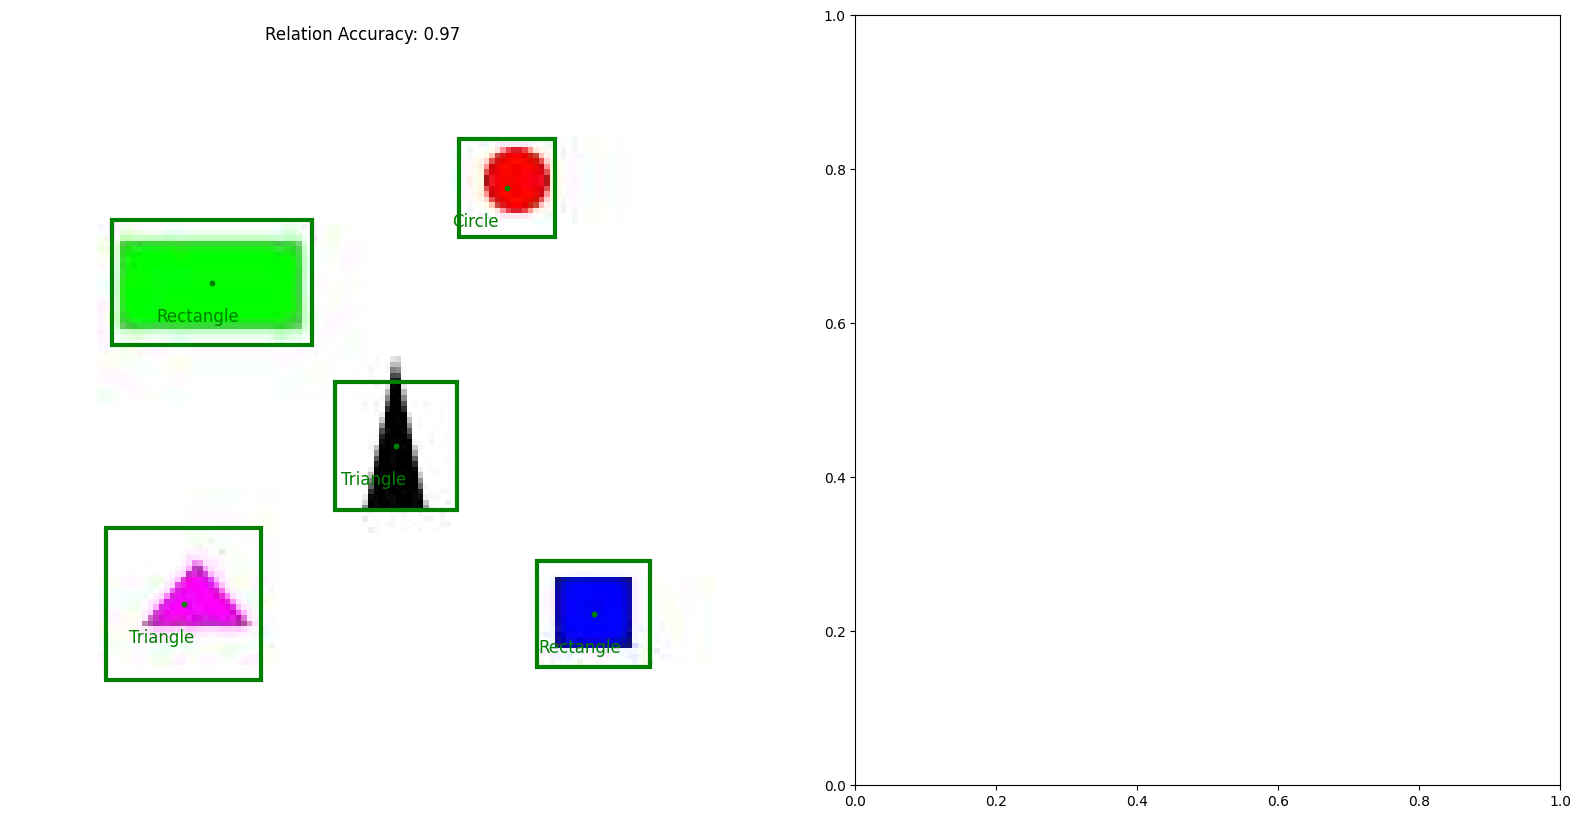

In [6]:
test_image_data, relation, out, out_relation = test_model(model, device, DATA_DIR)

In [21]:
print_relationships((th.sigmoid(out_relation[0]) > 0.5).int(), out)

Green Circle is Right of Red Circle
Red Circle is Left of Green Circle
Red Circle is Above of Green Circle
Green Circle is Below of Red Circle
Green Circle is Front of Red Circle
Red Circle is Behind of Green Circle


In [20]:
print_relationships(relation[0], out)

Red Circle is Above of Green Circle
Green Circle is Below of Red Circle
Green Circle is Front of Red Circle
Red Circle is Behind of Green Circle
